In [9]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from shogun import *
from scripts import utils
from datetime import datetime, timedelta

import time

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

In [10]:
# SQL database config
sqluser = 'o4nguyen'
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = 'hdsldb.uwaterloo.ca'
port = 5432
pwd = getpass.getpass()

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

········


In [11]:
%%time
query_output = utils.get_query_from_file('sql/vitals-lagged-full.sql', con)


DatabaseError: Execution failed on sql '-- This query pivots the time series vital signs for the first 24 hours of a patient's stay
-- Vital signs include heart rate, blood pressure, respiration rate, and temperature

set search_path to mimiciii;
WITH stg AS 
(
    SELECT pvt.subject_id,
    pvt.hadm_id,
    pvt.icustay_id,
    pvt."timestamp",
        CASE
            WHEN pvt.vitalid = 1 THEN pvt.valuenum
            ELSE NULL::double precision
        END AS heartrate,
        CASE
            WHEN pvt.vitalid = 2 THEN pvt.valuenum
            ELSE NULL::double precision
        END AS sysbp,
        CASE
            WHEN pvt.vitalid = 3 THEN pvt.valuenum
            ELSE NULL::double precision
        END AS diasbp,
        CASE
            WHEN pvt.vitalid = 4 THEN pvt.valuenum
            ELSE NULL::double precision
        END AS meanbp,
        CASE
            WHEN pvt.vitalid = 5 THEN pvt.valuenum
            ELSE NULL::double precision
        END AS resprate,
        CASE
            WHEN pvt.vitalid = 6 THEN pvt.valuenum
            ELSE NULL::double precision
        END AS tempc,
        CASE
            WHEN pvt.vitalid = 7 THEN pvt.valuenum
            ELSE NULL::double precision
        END AS spo2
    FROM ( SELECT ie.subject_id,
            ie.hadm_id,
            ie.icustay_id,
            date_trunc('hour'::text, ce.charttime) AS "timestamp",
                CASE
                    WHEN (ce.itemid = ANY (ARRAY[211, 220045])) AND ce.valuenum > 0::double precision AND ce.valuenum < 300::double precision THEN 1
                    WHEN (ce.itemid = ANY (ARRAY[51, 442, 455, 6701, 220179, 220050])) AND ce.valuenum > 0::double precision AND ce.valuenum < 400::double precision THEN 2
                    WHEN (ce.itemid = ANY (ARRAY[8368, 8440, 8441, 8555, 220180, 220051])) AND ce.valuenum > 0::double precision AND ce.valuenum < 300::double precision THEN 3
                    WHEN (ce.itemid = ANY (ARRAY[456, 52, 6702, 443, 220052, 220181, 225312])) AND ce.valuenum > 0::double precision AND ce.valuenum < 300::double precision THEN 4
                    WHEN (ce.itemid = ANY (ARRAY[615, 618, 220210, 224690])) AND ce.valuenum > 0::double precision AND ce.valuenum < 70::double precision THEN 5
                    WHEN (ce.itemid = ANY (ARRAY[223761, 678])) AND ce.valuenum > 70::double precision AND ce.valuenum < 120::double precision THEN 6
                    WHEN (ce.itemid = ANY (ARRAY[223762, 676])) AND ce.valuenum > 10::double precision AND ce.valuenum < 50::double precision THEN 6
                    WHEN (ce.itemid = ANY (ARRAY[646, 220277])) AND ce.valuenum > 0::double precision AND ce.valuenum <= 100::double precision THEN 7
                    ELSE NULL::integer
                END AS vitalid,
                CASE
                    WHEN ce.itemid = ANY (ARRAY[223761, 678]) THEN (ce.valuenum - 32::double precision) / 1.8::double precision
                    ELSE ce.valuenum
                END AS valuenum
            FROM mimiciii.icustays ie
                LEFT JOIN mimiciii.chartevents ce ON ie.subject_id = ce.subject_id AND ie.hadm_id = ce.hadm_id AND ie.icustay_id = ce.icustay_id AND ce.charttime >= ie.intime AND ce.charttime <= (ie.intime + '1 day'::interval day) AND ce.error IS DISTINCT FROM 1
            WHERE ce.itemid = ANY (ARRAY[211, 220045, 51, 442, 455, 6701, 220179, 220050, 8368, 8440, 8441, 8555, 220180, 220051, 456, 52, 6702, 443, 220052, 220181, 225312, 618, 615, 220210, 224690, 223761, 678, 223762, 676, 646, 220277])) pvt
    GROUP BY pvt.subject_id, pvt.hadm_id, pvt.icustay_id, pvt."timestamp", pvt.vitalid, pvt.valuenum
    ORDER BY pvt.subject_id, pvt.hadm_id, pvt.icustay_id
), agg AS 
(
    SELECT stg."timestamp",
    stg.subject_id,
    stg.hadm_id,
    stg.icustay_id,
    avg(stg.heartrate) AS heartrate,
    avg(stg.sysbp) AS sysbp,
    avg(stg.diasbp) AS diasbp,
    avg(stg.meanbp) AS meanbp,
    avg(stg.resprate) AS resprate,
    avg(stg.tempc) AS tempc,
    avg(stg.spo2) AS spo2
    FROM stg
    GROUP BY stg.icustay_id, stg.hadm_id, stg.subject_id, stg."timestamp"
    ORDER BY stg.icustay_id, stg.hadm_id, stg.subject_id, stg."timestamp"
)
, vitalsfirstday_timeseries AS 
(
    SELECT agg."timestamp",
    agg.subject_id,
    agg.hadm_id,
    agg.icustay_id,
    agg.heartrate AS hr,
    lag(agg.heartrate, 1) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS hr_1h,
    lag(agg.heartrate, 2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS hr_2h,
    lag(agg.heartrate, 3) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS hr_3h,
    avg(agg.heartrate) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS hr_mean_6h,
    min(agg.heartrate) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS hr_min_6h,
    max(agg.heartrate) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS hr_max_6h,
    median(agg.heartrate) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS hr_median_6h,
    agg.sysbp,
    lag(agg.sysbp, 1) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS sysbp_1h,
    lag(agg.sysbp, 2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS sysbp_2h,
    lag(agg.sysbp, 3) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS sysbp_3h,
    avg(agg.sysbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS sysbp_mean_6h,
    min(agg.sysbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS sysbp_min_6h,
    max(agg.sysbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS sysbp_max_6h,
    median(agg.sysbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS sysbp_median_6h,
    agg.diasbp,
    lag(agg.diasbp, 1) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS diasbp_1h,
    lag(agg.diasbp, 2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS diasbp_2h,
    lag(agg.diasbp, 3) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS diasbp_3h,
    avg(agg.diasbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS diasbp_mean_6h,
    min(agg.diasbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS diasbp_min_6h,
    max(agg.diasbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS diasbp_max_6h,
    median(agg.diasbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS diasbp_median_6h,
    agg.meanbp,
    lag(agg.meanbp, 1) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS meanbp_1h,
    lag(agg.meanbp, 2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS meanbp_2h,
    lag(agg.meanbp, 3) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS meanbp_3h,
    avg(agg.meanbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS meanbp_mean_6h,
    min(agg.meanbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS meanbp_min_6h,
    max(agg.meanbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS meanbp_max_6h,
    median(agg.meanbp) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS meanbp_median_6h,
    agg.resprate,
    lag(agg.resprate, 1) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS resprate_1h,
    lag(agg.resprate, 2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS resprate_2h,
    lag(agg.resprate, 3) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS resprate_3h,
    avg(agg.resprate) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS resprate_mean_6h,
    min(agg.resprate) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS resprate_min_6h,
    max(agg.resprate) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS resprate_max_6h,
    median(agg.resprate) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS resprate_median_6h,
    agg.tempc,
    lag(agg.tempc, 1) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS tempc_1h,
    lag(agg.tempc, 2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS tempc_2h,
    lag(agg.tempc, 3) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS tempc_3h,
    avg(agg.tempc) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS tempc_mean_6h,
    min(agg.tempc) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS tempc_min_6h,
    max(agg.tempc) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS tempc_max_6h,
    median(agg.tempc) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS tempc_median_6h,
    agg.spo2,
    lag(agg.spo2, 1) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS spo2_1h,
    lag(agg.spo2, 2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS spo2_2h,
    lag(agg.spo2, 3) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp") AS spo2_3h,
    avg(agg.spo2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS spo2_mean_6h,
    min(agg.spo2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS spo2_min_6h,
    max(agg.spo2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS spo2_max_6h,
    median(agg.spo2) OVER (ORDER BY agg.icustay_id, agg.subject_id, agg."timestamp" ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS spo2_median_6h
    FROM agg
    ORDER BY agg.subject_id, agg.hadm_id, agg.icustay_id, agg."timestamp";
)

-- Table : Services
, serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)

-- Table : Clinical data + demographics
, co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit, admission_type
, icu.los as icu_los
, round((EXTRACT(EPOCH FROM (adm.dischtime-adm.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age_icu_in
, icu.intime as icu_intime
, pat.gender
, pat.dod_hosp
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
, hospital_expire_flag
, CASE WHEN pat.dod IS NOT NULL 
       AND pat.dod >= icu.intime - interval '6 hour'
       AND pat.dod <= icu.outtime + interval '6 hour' THEN 1 
       ELSE 0 END AS icu_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '30' day THEN 1 
    ELSE 0 END as hospital30day_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '1' year THEN 1 
    ELSE 0 END as hospital1year_expire_flag      
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm
ON adm.hadm_id = icu.hadm_id    
)

-- Table : Exclusions
, excl AS
(
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_los, co.hosp_los
  , co.age_icu_in
  , co.gender
  , co.icustay_id_order
  , serv.curr_service
  , co.first_careunit
  , co.hospital_expire_flag
  , co.icu_expire_flag
  , CASE
        WHEN co.icu_los < 1 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age_icu_in < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
)

SELECT 

-- vital signs for the first 24 hours of the icu stay
vital.*

-- vital.icustay_id, vital.subject_id, vital.hadm_id
-- , HeartRate
-- , DiasBP
-- , SysBP
-- , MeanBP
-- , RespRate
-- , TempC
-- , SpO2

-- demographic data
, co.age_icu_in, co.first_careunit, co.gender, co.admission_type
, hw.height_first, hw.weight_first
, EXTRACT('epoch' from vital.timestamp - co.icu_intime) / 60.0 / 60.0 / 24.0 / 365.242 as icu_los
-- outcomes
, co.hospital_expire_flag, co.icu_expire_flag
, co.hosp_los, co.icu_los, co.icustay_id_order
, co.dod_hosp
, CASE 
    WHEN vital.timestamp >= co.dod_hosp THEN 1 
    ELSE 0 END 
    AS dead
, CASE 
    WHEN vital.timestamp + interval '1' day >= co.dod_hosp THEN 1 
    ELSE 0 END 
    AS dead_in_1d
, CASE 
    WHEN vital.timestamp + interval '7' day >= co.dod_hosp THEN 1 
    ELSE 0 END 
    AS dead_in_7d
, CASE 
    WHEN vital.timestamp + interval '30' day >= co.dod_hosp THEN 1 
    ELSE 0 END 
    AS dead_in_30d

-- exclusions
, excl.exclusion_los, excl.exclusion_age
, excl.exclusion_first_stay, excl.exclusion_surgical

FROM vitalsfirstday_timeseries vital
left join co
  ON vital.icustay_id = co.icustay_id
left join excl
  on vital.icustay_id = excl.icustay_id;
': syntax error at or near ";"
LINE 143: ...gg.subject_id, agg.hadm_id, agg.icustay_id, agg."timestamp";
                                                                        ^


In [4]:
%%time
query_output = utils.get_query_from_file('sql/firstday-lagged-materialized.sql', con)
query_output.to_csv('./vitals-lagged.csv', index=False)

CPU times: user 1min 23s, sys: 10.4 s, total: 1min 33s
Wall time: 3min 2s


In [2]:
query_output = pd.read_csv('./vitals-lagged.csv') #, index_col='timestamp') #.dropna().reset_index(drop=True)

query_output = query_output.dropna(subset=['timestamp'], how='any')
query_output= query_output.set_index('timestamp')

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'dod_hosp', 'dead_in_1d', 'dead_in_7d']

# Demographic information
demographics =  ['subject_id', 'age_icu_in', 'gender', 
                 'first_careunit', 'admission_type']

vital_signs = ['hr', 'diasbp', 'sysbp', 'meanbp', 'resprate', 'tempc', 'spo2']
features = [[v, v + '_mean_6h', v + '_median_6h', v + '_max_6h', v + '_min_6h', 
             v + '_1h', v + '_2h', v + '_3h'] for v in vital_signs]
feature_names = []
for f in features:
    feature_names += f
    
# feature_names[0] = 'heartrate'

query_output = query_output.loc[:, mortality_names + demographics + feature_names]
query_output = query_output.fillna(query_output.mean())
query_output.index = pd.to_datetime(query_output.index)

# Remove points after a patient has already died
will_die = (~query_output.dod_hosp.isnull())
point_after_dead = (query_output.index > pd.DatetimeIndex(query_output.dod_hosp))
query_output = query_output.loc[~(will_die & point_after_dead)]

# Undersample negative data points
"""
will_survive = (query_output.dod_hosp.isnull())
will_die = ~will_survive
num_to_remove = len(will_survive)
to_remove = np.random.choice(np.where(will_survive == True)[0], num_to_remove)
will_survive[to_remove] = False
query_output = query_output.loc[will_survive | will_die]
"""

df_labels = query_output.loc[:, mortality_names]
df_features = query_output.loc[:, query_output.columns.difference(mortality_names)]

df_features.head()

,admission_type,age_icu_in,diasbp,diasbp_1h,diasbp_2h,diasbp_3h,diasbp_max_6h,diasbp_mean_6h,diasbp_median_6h,diasbp_min_6h,...,sysbp_median_6h,sysbp_min_6h,tempc,tempc_1h,tempc_2h,tempc_3h,tempc_max_6h,tempc_mean_6h,tempc_median_6h,tempc_min_6h
timestamp,,,,,,,,,,,,,,,,,,,,,
2111-11-07 02:00:00,1,37.446714,54.0,60.571963,60.579264,60.588039,54.0,53.500000,53.5,53.0,...,107.5,107.0,37.388891,36.975663,36.972327,36.967630,37.388891,37.388891,37.388891,37.388891
2111-11-07 03:00:00,1,37.446714,60.0,54.000000,60.579264,60.588039,60.0,55.666667,54.0,53.0,...,107.0,107.0,36.978712,37.388891,36.972327,36.967630,37.388891,37.388891,37.388891,37.388891
2111-11-07 04:00:00,1,37.446714,56.0,60.000000,54.000000,60.588039,60.0,55.750000,55.0,53.0,...,107.0,102.0,36.978712,36.975663,37.388891,36.967630,37.388891,37.388891,37.388891,37.388891
2111-11-07 05:00:00,1,37.446714,50.0,56.000000,60.000000,54.000000,60.0,55.000000,55.0,50.0,...,104.5,96.0,36.978712,36.975663,36.972327,37.388891,37.388891,37.388891,37.388891,37.388891
2111-11-07 06:00:00,1,37.446714,40.5,50.000000,56.000000,60.000000,60.0,52.100000,54.0,40.5,...,102.0,94.0,36.777778,36.975663,36.972327,36.967630,37.388891,37.083334,37.083334,36.777778


## Visualizations

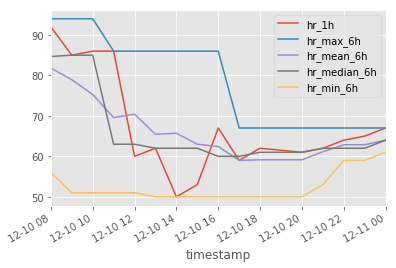

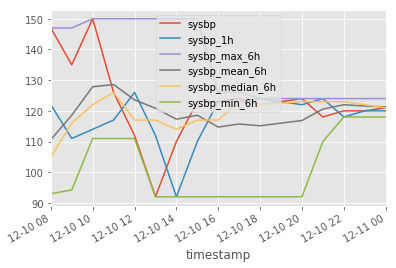

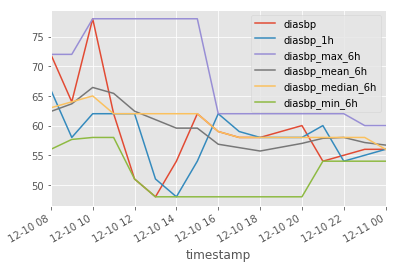

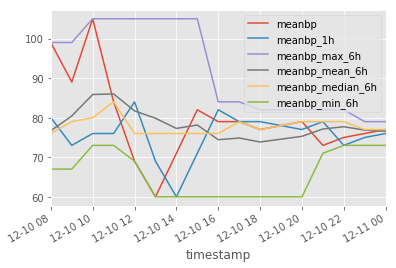

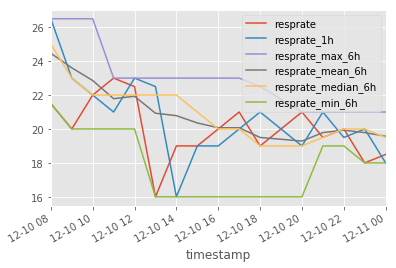

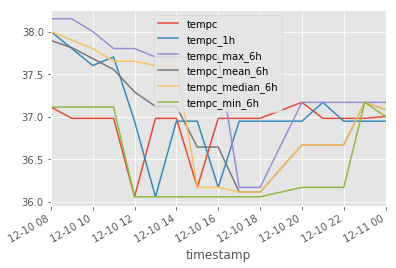

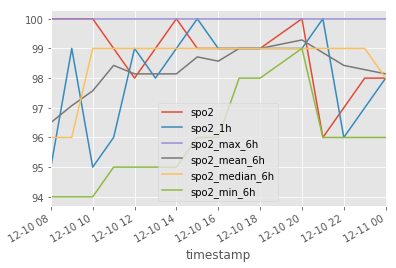

In [27]:
non_surv_rows = np.random.choice(non_survival.subject_id.values, 1)
non_survival = non_survival.loc[non_survival.subject_id.isin(non_surv_rows)]

feats = ['hr', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2']
for title, group in non_survival.groupby('subject_id'):
    for f in feats:
        group.filter(regex=f).plot()

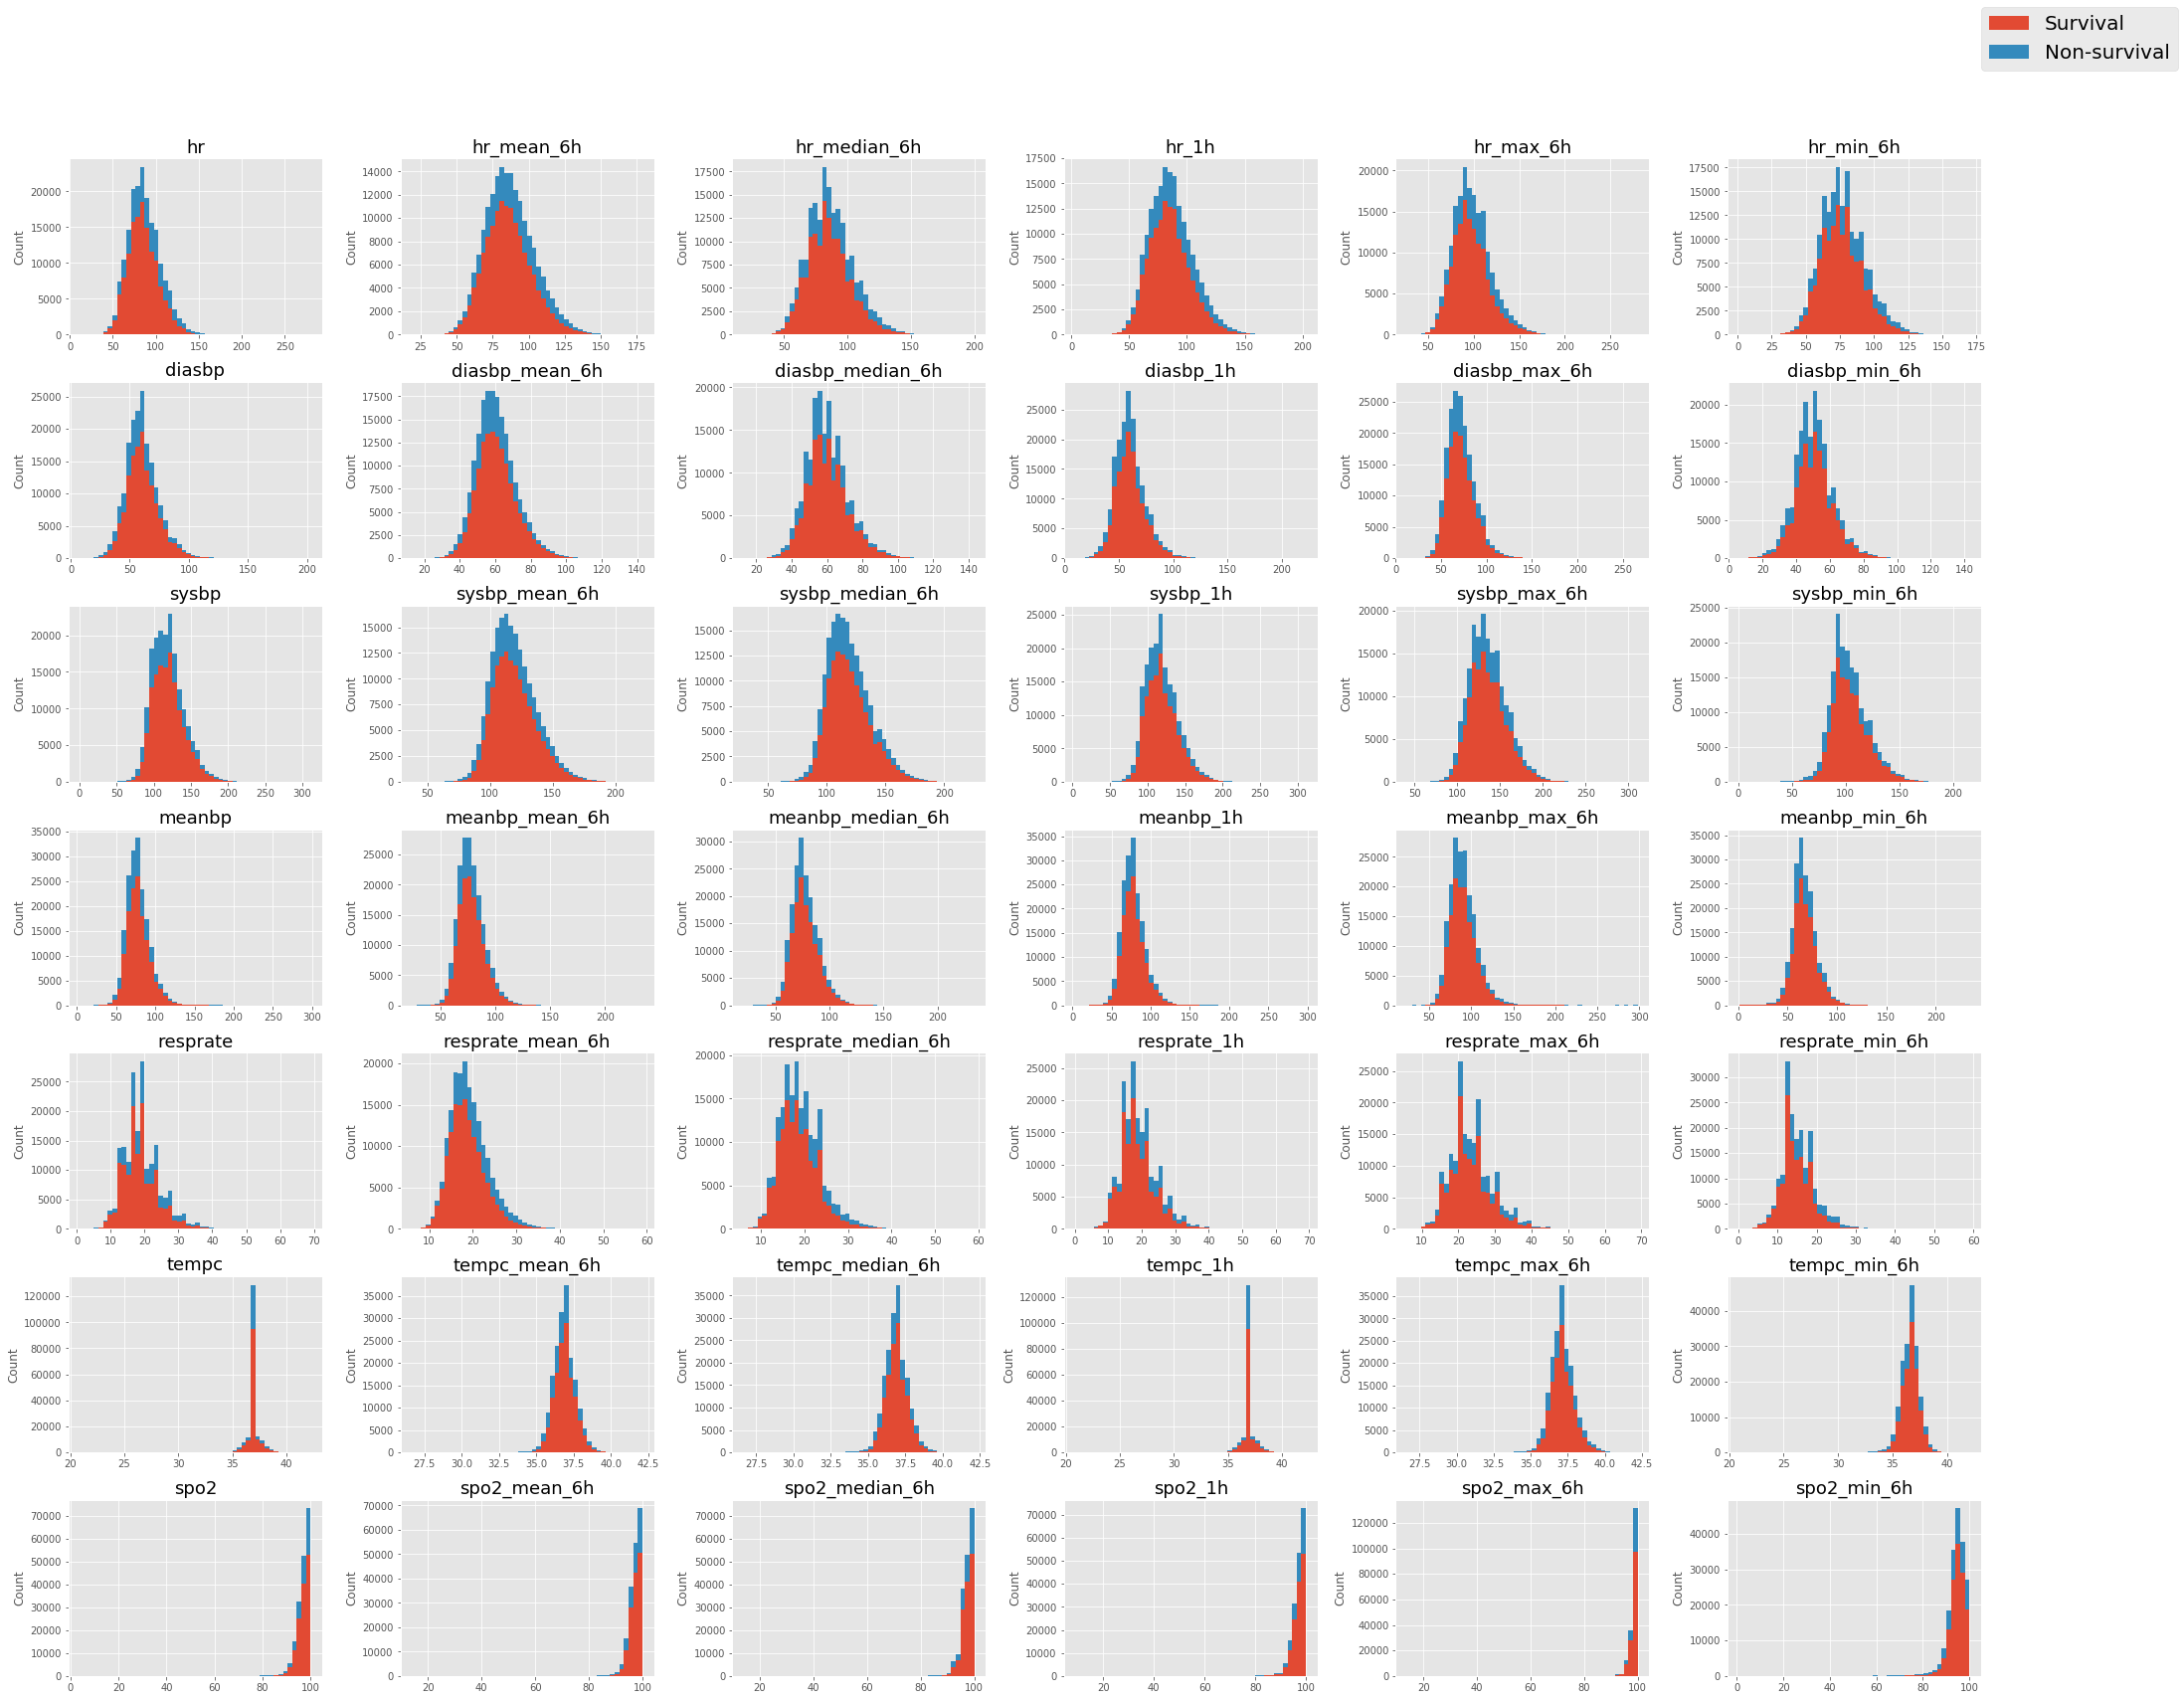

In [12]:
will_die = (~query_output.dod_hosp.isnull())
died = query_output.loc[will_die]
survived = query_output.loc[~will_die]

survived = df_features.loc[df_labels.dead_in_7d == 0].sample(frac=0.20)
died = df_features.loc[df_labels.dead_in_7d != 0]

f, axarr = plt.subplots(7, 6, figsize=(28, 22))

i = -1
for idx, feature_name in enumerate(feature_names):
    x1 = survived.loc[:, feature_name].dropna()
    x2 = died.loc[:, feature_name].dropna()
    if idx % 6 == 0:
        i += 1
    p = axarr[i, idx % 6].hist([x1, x2], stacked=True, bins=50, normed=False)
    axarr[i, idx % 6].set_ylabel('Count')
    axarr[i, idx % 6].set_title(feature_name, fontsize=18)
    
axarr[0, 5].legend(['Survival', 'Non-survival'], loc=(1, 1.5), fontsize=20)
    
plt.tight_layout()

## Data preparation

In [4]:
X = df_features.drop('subject_id', axis=1).reset_index(drop=True)
y = df_labels['dead_in_7d'].reset_index(drop=True)

dataset_size = 100000
subset_idx = np.random.choice(len(df_features), dataset_size)

X = X.loc[subset_idx].reset_index(drop=True)
y = y.loc[subset_idx].reset_index(drop=True)

split = int(len(X) * 0.5)

idx = np.random.permutation(np.arange(len(y)))
train_idx = idx[:split]
test_idx = idx[split:]

X_train = RealFeatures(np.array(X.loc[train_idx].T))
X_test = RealFeatures(np.array(X.loc[test_idx].T))

y_train = MulticlassLabels(np.array(y.loc[train_idx]).astype(np.float))
y_test = MulticlassLabels(np.array(y.loc[test_idx]).astype(np.float))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

('Number of training samples:', 50000)
('Number of testing samples:', 50000)


True

In [5]:
print("Number of positive (death) labels: ", sum(y == 1))
print("Number of negative (alive) labels: ", sum(y == 0))

print("positive/negative ratio:", sum(y == 0) / float(sum(y == 1)))

('Number of positive (death) labels: ', 6473)
('Number of negative (alive) labels: ', 93527)
('positive/negative ratio:', 14.44878727019929)


## SVM

In [6]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply_binary(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test.get_binary_for_class(1))

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 93.396)
('Area under ROC(%):', 0.7266923626610214)
CPU times: user 3.56 s, sys: 0 ns, total: 3.56 s
Wall time: 1.01 s


In [7]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
svm.set_liblinear_solver_type(L2R_LR)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply_binary(X_test)

lr_roc = ROCEvaluation()
lr_roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = lr_roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.728990361122668)
CPU times: user 3.51 s, sys: 0 ns, total: 3.51 s
Wall time: 1 s


## Hyperparameter tuning

In [8]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001
aucs = []
for c in [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]:
    svm = LibLinear(c, X_train, y_train.get_binary_for_class(1))
    svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
    svm.set_epsilon(epsilon)

    svm.train()

    y_pred = svm.apply_binary(X_test)

    roc = ROCEvaluation()
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))

    auc = roc.get_auROC()
    aucs.append(auc)
    print(svm.get_C1(), "Area under ROC(%):", auc)

(0.0, 'Area under ROC(%):', 0.5)
(0.01, 'Area under ROC(%):', 0.726678192457378)
(0.1, 'Area under ROC(%):', 0.7266923626610214)
(1.0, 'Area under ROC(%):', 0.7266949372929975)
(10.0, 'Area under ROC(%):', 0.7266945222389782)
(100.0, 'Area under ROC(%):', 0.7266951318495695)
(1000.0, 'Area under ROC(%):', 0.7266977324224156)
CPU times: user 19.6 s, sys: 48 ms, total: 19.7 s
Wall time: 5.54 s


## Random Forest

In [20]:
%%time
n_trees = 100

feature_types = np.zeros_like(X.columns, dtype=bool)
feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True

m_vote = MeanRule()

rand_forest = RandomForest(X_train, y_train, n_trees)
rand_forest.set_combination_rule(m_vote)
rand_forest.set_feature_types(feature_types)

rand_forest.train()

y_pred = rand_forest.apply_binary(X_test)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test.get_binary_for_class(1))

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.8313112879336093)
CPU times: user 10min 10s, sys: 3.38 s, total: 10min 14s
Wall time: 3min 12s


## Sampling 100,000 points

In [99]:
%%time
dataset_size = 100000
n_trees = 100
feature_types = np.zeros_like(X.columns, dtype=bool)
feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True

svm_aucs = []
lr_aucs = []
rf_aucs = []
roc = ROCEvaluation()

for i in range(10):
    
    X = df_features.drop('subject_id', axis=1).reset_index(drop=True)
    y = df_labels['dead_in_1d'].reset_index(drop=True)    
    # Randomly select 100,000 points
    subset_idx = np.random.choice(len(y), dataset_size)
    X = X.loc[subset_idx].reset_index(drop=True)
    y = y.loc[subset_idx].reset_index(drop=True)

    split = int(len(X) * 0.5)

    idx = np.random.permutation(np.arange(len(y)))
    train_idx = idx[:split]
    test_idx = idx[split:]

    X_train = RealFeatures(np.array(X.loc[train_idx].T))
    X_test = RealFeatures(np.array(X.loc[test_idx].T))

    y_train = MulticlassLabels(np.array(y.loc[train_idx]).astype(np.float))
    y_test = MulticlassLabels(np.array(y.loc[test_idx]).astype(np.float))

    preprocessor = PruneVarSubMean(True)
    preprocessor.init(X_train)
    X_train.add_preprocessor(preprocessor)
    X_train.apply_preprocessor(True)

    preprocessor.init(X_test)
    X_test.add_preprocessor(preprocessor)
    X_test.apply_preprocessor(True)    
    
    # SVM
    svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
    svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
    svm.set_epsilon(epsilon)
    svm.train()
    y_pred = svm.apply_binary(X_test)
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))
    auc = roc.get_auROC()
    svm_aucs.append(auc)
    
    # Logistic regression
    svm = LibLinear(C, X_train, y_train.get_binary_for_class(1))
    svm.set_liblinear_solver_type(L2R_LR)
    svm.set_epsilon(epsilon)
    svm.train()
    y_pred = svm.apply_binary(X_test)
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))
    auc = roc.get_auROC()
    lr_aucs.append(auc)
    
    # Random Forest
    feature_types = np.zeros_like(X.columns, dtype=bool)
    feature_types[np.where( (X.columns == 'admission_type') | (X.columns == 'first_careunit') |(X.columns == 'gender'))[0]] = True
    
    m_vote = MeanRule()
    rand_forest = RandomForest(X_train, y_train, n_trees)
    rand_forest.set_combination_rule(m_vote)
    rand_forest.set_feature_types(feature_types)
    rand_forest.train()
    y_pred = rand_forest.apply_binary(X_test)
    roc.evaluate(y_pred, y_test.get_binary_for_class(1))
    auc = roc.get_auROC()
    print(auc)
    rf_aucs.append(auc)

0.786942159003
0.770087874176
0.783132809843
0.793954322144
0.788214041079
0.781461674795
0.786556314303
0.783661404784
0.794555560961
0.781883672388
CPU times: user 46min 34s, sys: 9.93 s, total: 46min 43s
Wall time: 13min 29s


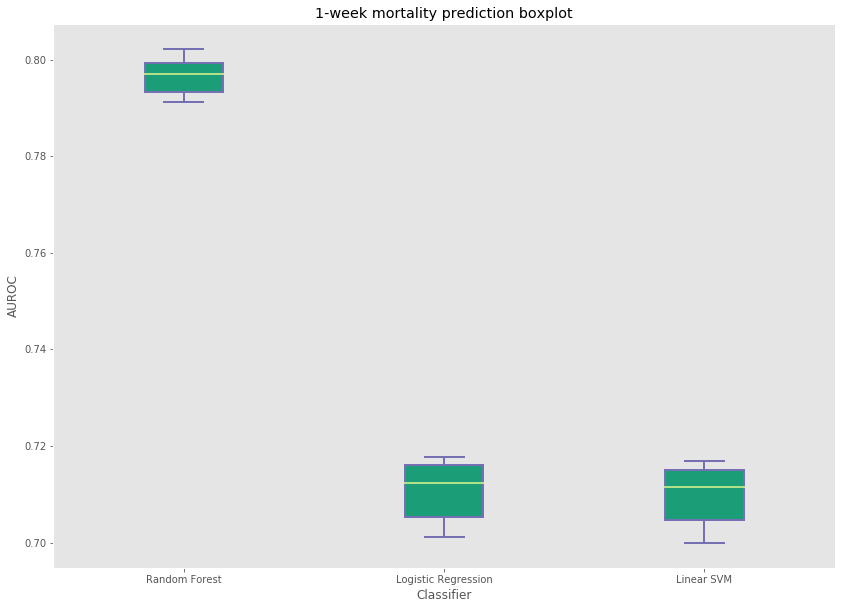

In [91]:
# styling taken from http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

aucs = [rf_aucs, lr_aucs, svm_aucs]
data = np.array(aucs).T
xlabels = [0, 1, 2] #[clf for clf in results]

plt.figure(figsize=(14, 10))
bp = plt.boxplot(data, 0, 'gD', patch_artist=True)
plt.ylabel('AUROC')
plt.xlabel('Classifier')
plt.xticks([1, 2, 3], ['Random Forest', 'Logistic Regression', 'Linear SVM'])
plt.title('1-week mortality prediction boxplot')
plt.grid(b=False)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
plt.show()

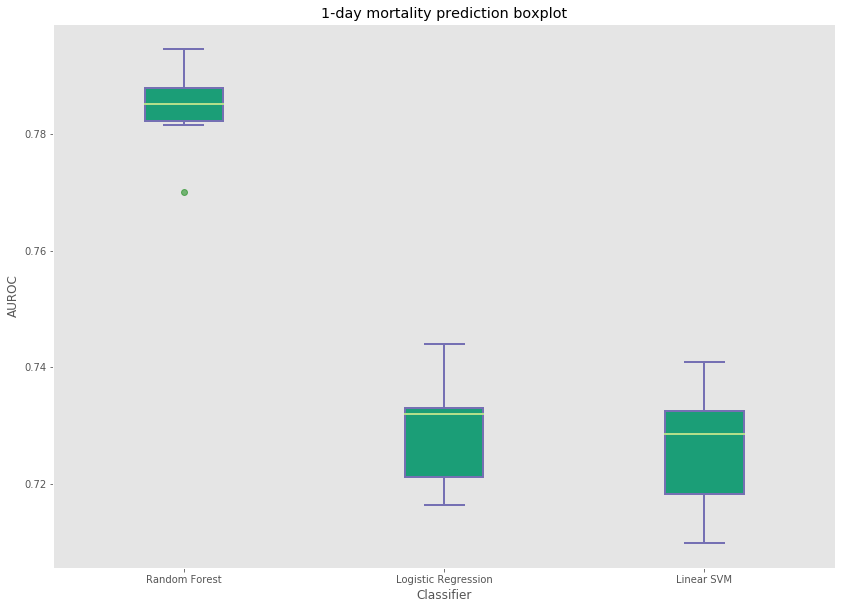

In [101]:
# styling taken from http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

aucs = [rf_aucs, lr_aucs, svm_aucs]
data = np.array(aucs).T
xlabels = [0, 1, 2] #[clf for clf in results]

plt.figure(figsize=(14, 10))
bp = plt.boxplot(data, 0, 'gD', patch_artist=True)
plt.ylabel('AUROC')
plt.xlabel('Classifier')
plt.xticks([1, 2, 3], ['Random Forest', 'Logistic Regression', 'Linear SVM'])
plt.title('1-day mortality prediction boxplot')
plt.grid(b=False)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
plt.show()

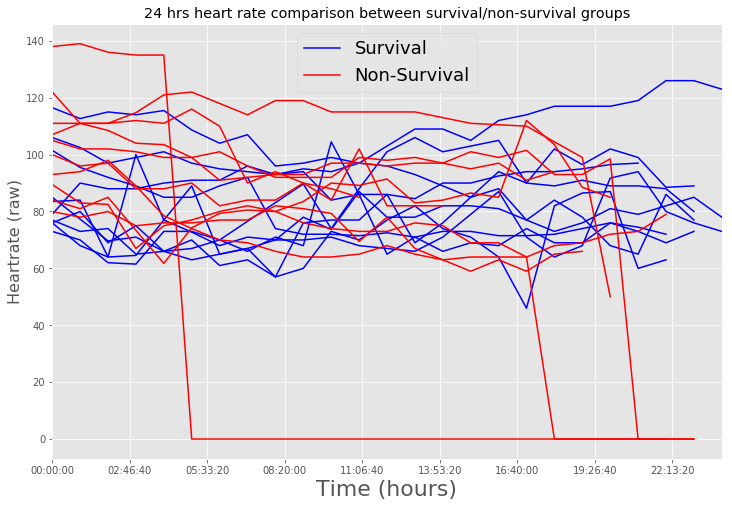

In [37]:
survival = df_features.loc[df_labels.dead_in_1d == 0]
non_survival = df_features.loc[df_labels.dead_in_1d != 0]

surv_rows = np.random.choice(survival.subject_id.values, 10)
non_surv_rows = np.random.choice(non_survival.subject_id.values, 10)

survival = survival.loc[survival.subject_id.isin(surv_rows)]
non_survival = non_survival.loc[non_survival.subject_id.isin(non_surv_rows)]

fig, ax = plt.subplots(figsize=(12, 8))

for title, group in survival.groupby('subject_id'):
    group.plot(y='heartrate', x=group.index - group.index[0], label='survival', ax=ax, color='blue')

for title, group in non_survival.groupby('subject_id'):
    death_time = pd.to_datetime(query_output[query_output.subject_id == title].dod_hosp[0])
    group.loc[group.index > death_time, 'heartrate'] = 0
    group.plot(y='heartrate', x=group.index - group.index[0], label='non-survival', ax=ax, color='red')    

legend = plt.legend(['Survival', 'Non-Survival'], fontsize=18)
legend.get_lines()[1].set_color('red')
plt.xlabel('Time (hours)', fontsize=22)
plt.ylabel('Heartrate (raw)', fontsize=16)
plt.title('24 hrs heart rate comparison between survival/non-survival groups')

plt.show()